# Imports

In [ ]:
import numpy as np
import pandas as pd
import os
import json


from transformers import AutoTokenizer

from tqdm import tqdm
import tensorflow as tf

import matplotlib.pyplot as plt

import os
import joblib
import numpy as np
import tensorflow as tf
from flask import Flask, request, jsonify
from functools import wraps
from transformers import TFAutoModelForTokenClassification, AutoTokenizer

# Preprocessing

In [3]:
def load_sentences(filepath):

    final = []
    sentences = []

    with open(filepath, 'r') as f:
        
        for line in f.readlines():
            
            if (line == ('-DOCSTART- -X- -X- O\n') or line == '\n'):
                if len(sentences) > 0:
                    final.append(sentences)
                    sentences = []
            else:
                l = line.split(' ')
                sentences.append((l[0], l[3].strip('\n')))
    
    return final

In [4]:

base_path = '../input/conll003-englishversion/'

train_samples = load_sentences(base_path + 'train.txt')
test_samples = load_sentences(base_path + 'test.txt')
valid_samples = load_sentences(base_path + 'valid.txt')

samples = train_samples + test_samples

schema = ['_'] + sorted({tag for sentence in samples 
                             for _, tag in sentence})

# Model

In [5]:
from transformers import AutoConfig, TFAutoModelForTokenClassification

MODEL_NAME = 'bert-base-cased' 

config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=len(schema))
model = TFAutoModelForTokenClassification.from_pretrained(MODEL_NAME, 
                                                          config=config)
model.summary()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForTokenClassification.

Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_token_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  107719680 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  7690      
Total params: 107,727,370
Trainable params: 107,727,370
Non-trainable params: 0
_________________________________________________________________


# Preprocessing

In [6]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_sample(sample):
    seq = [
               (subtoken, tag)
               for token, tag in sample
               for subtoken in tokenizer(token)['input_ids'][1:-1]
           ]
    return [(3, 'O')] + seq + [(4, 'O')]

def preprocess(samples):
    tag_index = {tag: i for i, tag in enumerate(schema)}
    tokenized_samples = list(tqdm(map(tokenize_sample, samples)))
    max_len = max(map(len, tokenized_samples))
    X = np.zeros((len(samples), max_len), dtype=np.int32)
    y = np.zeros((len(samples), max_len), dtype=np.int32)
    for i, sentence in enumerate(tokenized_samples):
        for j, (subtoken_id, tag) in enumerate(sentence):
            X[i, j] = subtoken_id
            y[i,j] = tag_index[tag]
    return X, y

X_train, y_train = preprocess(train_samples)
X_test, y_test = preprocess(test_samples)
X_valid, y_valid = preprocess(valid_samples)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

14041it [00:08, 1564.25it/s]
3453it [00:02, 1560.74it/s]
3250it [00:02, 1472.10it/s]


# Training

In [7]:
EPOCHS=5
BATCH_SIZE=8

optimizer = tf.keras.optimizers.Adam(lr=0.000001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
history = model.fit(tf.constant(X_train), tf.constant(y_train),
                    validation_data=(X_test, y_test), 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE)

Epoch 1/5
1756/1756 [==============================] - 693s 383ms/step - loss: 0.3525 - accuracy: 0.9150 - val_loss: 0.0653 - val_accuracy: 0.9804
Epoch 2/5
1756/1756 [==============================] - 681s 388ms/step - loss: 0.0546 - accuracy: 0.9839 - val_loss: 0.0378 - val_accuracy: 0.9888
Epoch 3/5
1756/1756 [==============================] - 680s 388ms/step - loss: 0.0328 - accuracy: 0.9902 - val_loss: 0.0305 - val_accuracy: 0.9907
Epoch 4/5
1756/1756 [==============================] - 681s 388ms/step - loss: 0.0232 - accuracy: 0.9931 - val_loss: 0.0240 - val_accuracy: 0.9928
Epoch 5/5
1756/1756 [==============================] - 680s 388ms/step - loss: 0.0179 - accuracy: 0.9948 - val_loss: 0.0221 - val_accuracy: 0.9939


# Saving the model

In [23]:
# Save the model
model.save_pretrained("saved_model")
tokenizer.save_pretrained("saved_model")


# Save the schema separately
with open('./saved_model/schema.json', 'w') as f:
    json.dump(schema, f)

# Zipping Model files and Labels 

In [20]:
!zip -r /kaggle/working/saved_model.zip /kaggle/working/saved_model

  adding: kaggle/working/saved_model/ (stored 0%)
  adding: kaggle/working/saved_model/vocab.txt (deflated 49%)
  adding: kaggle/working/saved_model/config.json (deflated 57%)
  adding: kaggle/working/saved_model/tf_model.h5 (deflated 7%)
  adding: kaggle/working/saved_model/tokenizer_config.json (deflated 37%)
  adding: kaggle/working/saved_model/special_tokens_map.json (deflated 40%)


## Training results

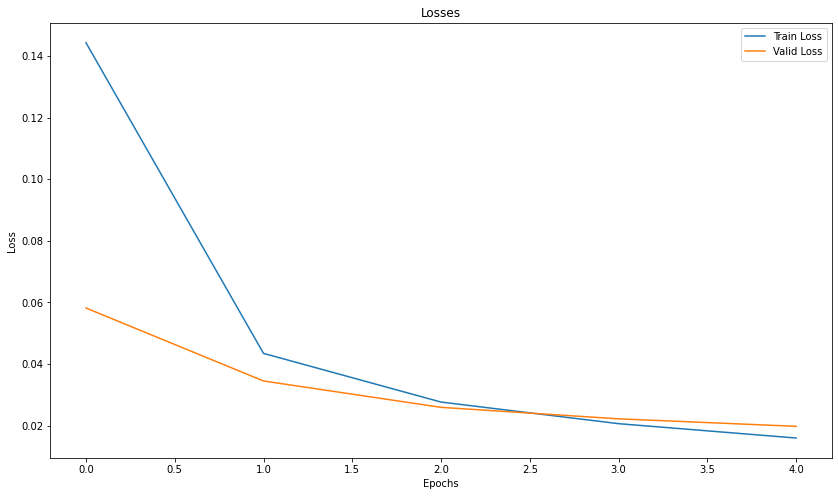

In [8]:
plt.figure(figsize=(14,8))
plt.title('Losses')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Valid Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

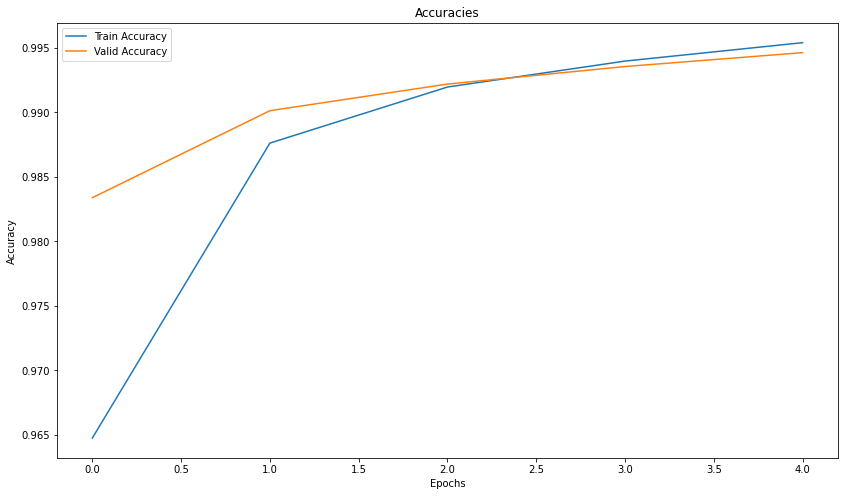

In [9]:
plt.figure(figsize=(14,8))
plt.title('Accuracies')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Valid Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## Validation results

In [10]:
[loss, accuracy] = model.evaluate(X_valid, y_valid)
print("Loss:%1.3f, Accuracy:%1.3f" % (loss, accuracy))

102/102 [==============================] - 44s 411ms/step - loss: 0.0155 - accuracy: 0.9956
Loss:0.016, Accuracy:0.996
